## Simon's Algorithm

In Simon's algorithm, we are given a black box function $f(x)$, and told that $f(x) = f(y) <=> x \oplus y \in \{0, a\}$ where $a$ is the special string we want to find. The goal is to find this $a$ in as few oracle queries as possible. 

Suppose we had the following truth table for $f(x)$ (working with 3 (qu)bits). 

| x   | f(x)|
| ----| ----|
| 000 | 101 |
| 001 | 010 |
| 010 | 000 |
| 011 | 110 |
| 100 | 000 |
| 101 | 110 |
| 110 | 101 |
| 111 | 110 |

Like last week, we're going to start by trying to solve this classically. What we'll do is pick random x values, see if f(x) is the same as any previously seen values and if so what the sum (mod 2) of they are.

In [1]:
import random
import numpy as np


def bitwise_add(x, y):
    z = ''
    for i in range(3):
        z  += str(int(x[i]) ^ int(y[i])) # ^ means bitwise add - this is probably not the cleanest way of doing this
    return z

def classical_simon():
    x_values = ['000', '001', '010', '011', '100', '101', '110', '111']
    
    f = {'000': '101', '001': '010', '010':'000', '011':'110', '100':'000', '101':'110', '110':'101', '111':'010'}
    
    f_values = {}
    
    queries = 0
    
    while len(x_values) > 0:
        x = random.choice(x_values)
        x_values.remove(x)
        
        y = f[x]
        queries += 1
        
        if y in f_values:
            if bitwise_add(x, f_values[y]) == '000':
                pass
            else:
                print(x, f_values[y], bitwise_add(x, f_values[y]), f_values)
                print("found a =", bitwise_add(x, f_values[y]), "in ", queries, "queries")
                return queries
        else:
            f_values[y] = x



classical_simon()            
#print("\n\nmean queries = ", np.mean([classical_simon() for _ in range(50)]))
        

000 110 110 {'000': '100', '010': '001', '110': '011', '101': '110'}
found a = 110 in  5 queries


5

Meanwhile, recall the quantum algorithm works as follows:
- Take 2 registers of size n
- Apply hadamards on the first register
- Apply $U_f$ which applies f(x) to the first register and stores the result in the second register
- Measure the second register
- Apply hadamards on the first register
- Measure the first register

The first thing we need to do is turn the function $f(x)$ into a gate. To do that, we first need to know the gate's matrix. We can do this by making the columns the outputs for the corresponding input on the identity matrix:

$|000\rangle\langle101| + |001\rangle\langle010| + |010\rangle\langle000| + |011\rangle\langle110| + |100\rangle\langle000| + |101\rangle\langle110| + |110\rangle\langle101| + |111\rangle\langle110| = \begin{bmatrix}  0 & 0 & 1 & 0 & 1 & 0 & 0 & 0 \\  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\  0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\  1 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\  0 & 0 & 0 & 1 & 0 & 1 & 0 & 1\\  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\end{bmatrix}$

We can convert this into a gate using qiskit's custom unitary. 
To make this store the result in the second register, we just CX all qubits from first to second. 

In [2]:
matrix = np.matrix([
    np.array([0, 0, 1, 0, 1, 0, 0, 0]),
    np.array([0, 0, 0, 0, 0, 0, 0, 0]),
    np.array([0, 1, 0, 0, 0, 0, 0, 0]),
    np.array([0, 0, 0, 0, 0, 0, 0, 0]),
    np.array([0, 0, 0, 0, 0, 0, 0, 0]),
    np.array([1, 0, 0, 0, 0, 0, 1, 0]),
    np.array([0, 0, 0, 1, 0, 1, 0, 1]),
    np.array([0, 0, 0, 0, 0, 0, 0, 0]),
])
matrix

matrix([[0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]])

In [3]:
matrix @ matrix.getH()

matrix([[2, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 2, 0, 0],
        [0, 0, 0, 0, 0, 0, 3, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]])

In [4]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.extensions import UnitaryGate



u = UnitaryGate(matrix, '$U_f$')

qc = QuantumCircuit(3)

qc += u

qc.draw(output='mpl')

ExtensionError: 'Input matrix is not unitary.'

## Quantum Fourier Transform (QFT)

Next, we'll consider the qft and how to implement it in qiskit.

Recall the circuit:

![](img/qft-circuit.png)

To build this in qiskit, we can just cheat and use the circuit library!

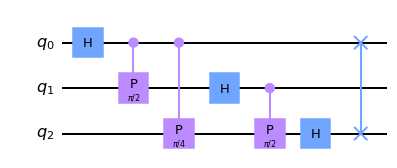

In [10]:
from qiskit.circuit.library import QFT

qc = QFT(3) # just give the number of qubits.
qc.draw(output='mpl')

Note that the gate being used is $P(\lambda) = \begin{bmatrix} 1 & 0\\ 1 & e^{i\lambda} \end{bmatrix}$

(https://qiskit.org/documentation/stubs/qiskit.circuit.library.PhaseGate.html)

Next let's see what these states look like for different inputs

Here's a helper function to perform qft on a custom state:

In [11]:
def qft_input(x='000', n=3):
    qc = QuantumCircuit(n)
    
    
    for i, y in enumerate(x):
        if y == "1": qc.x(i)
    qc.barrier()
    
    qc += QFT(n)
    
    return qc

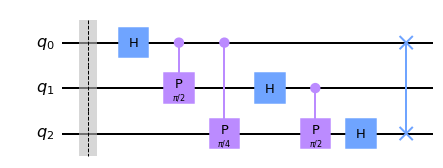

In [12]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere, plot_bloch_multivector
qc = qft_input('000')
qc.draw(output='mpl')

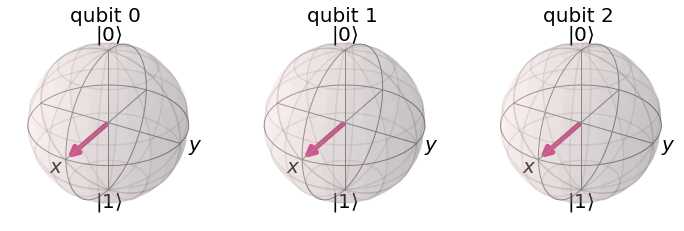

In [13]:
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

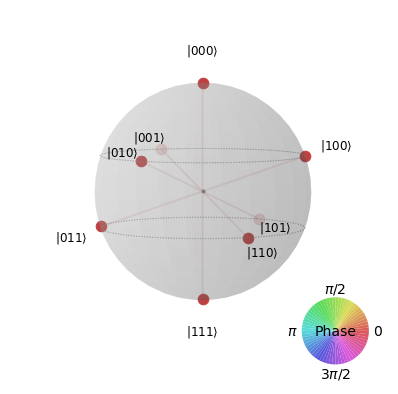

In [14]:
plot_state_qsphere(state)

## Application - faster addition

As we saw in lecture, we can use QFT to perform addition quite efficiently. In this part, we'll first look at "classical" addition and then compare it to using QFT.

By "classical" addition, I mean using only X and toffoli gates. The general scheme will be to have two registers, $A = |x\rangle$ and $B = |y\rangle$ and to then take the second register to $B = |x + y\rangle$.

We'll start with adding two n bit numbers. The technique I'll use is:
- Add the least significant bits in A and B => CX(a[0], b[0])
    - BUT if that flip increments b[0] from a 0 to a 1, we also need to increment b[1] (and so on, recursively)
- Repeat for (a[1], b[1]), ... ,(a[n], b[n])

NB - always assume least significant bit is highest

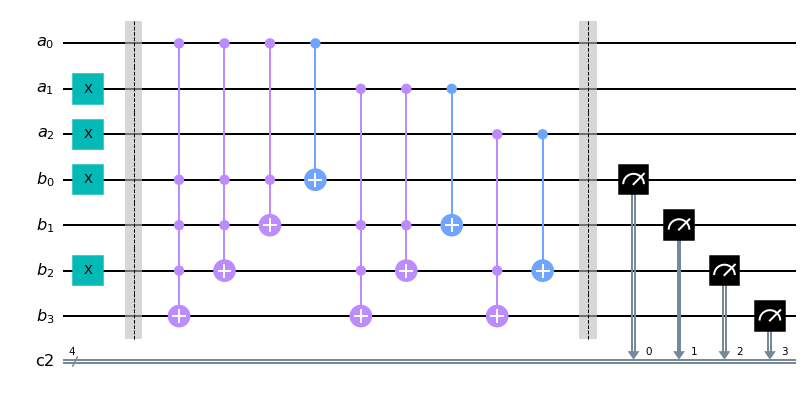

In [15]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def classical_add(x, y):
    assert len(x) == len(y)
    
    n = len(x)

    A = QuantumRegister(n, name="a")
    B = QuantumRegister(n + 1, name="b") # B has an extra bit in case the sum is > 4
    qc = QuantumCircuit(A, B, ClassicalRegister(n+1))
    
    ## Prepare inputs
    for i in range(n):
        if x[::-1][i] == "1": qc.x(A[i])
        
        if y[::-1][i] == "1": qc.x(B[i])
            
    qc.barrier()
    
    for i in range(n):
        for j in range(i, n+1)[::-1]:
            qc.mct([A[i]]+[B[k] for k in range(i,j)], B[j]) # flips bit recursively if previous bit is going to be flipped
    
    qc.barrier()
    qc.measure(B, range(n+1))
    
    return qc



qc_class = classical_add('110', '101')
qc_class.draw(output='mpl')



In [16]:
from qiskit import BasicAer, execute
backend = BasicAer.get_backend('qasm_simulator')
results = execute(qc_class, backend, shots=1024).result().get_counts()
results

{'1011': 1024}

The "cost" of a quantum circuit is very important because on noisy devices the longer the circuit, the more errors you're likely to get. 

There are a number of ways to compare of  quantum circuits. We'll look at the number of gates in the circuit once it has been transpiled into standard "basis gates". Recall from the previous module that we can make a universal set using arbitray 1-qubit rotations and CX gates, so that's what we'll use below:

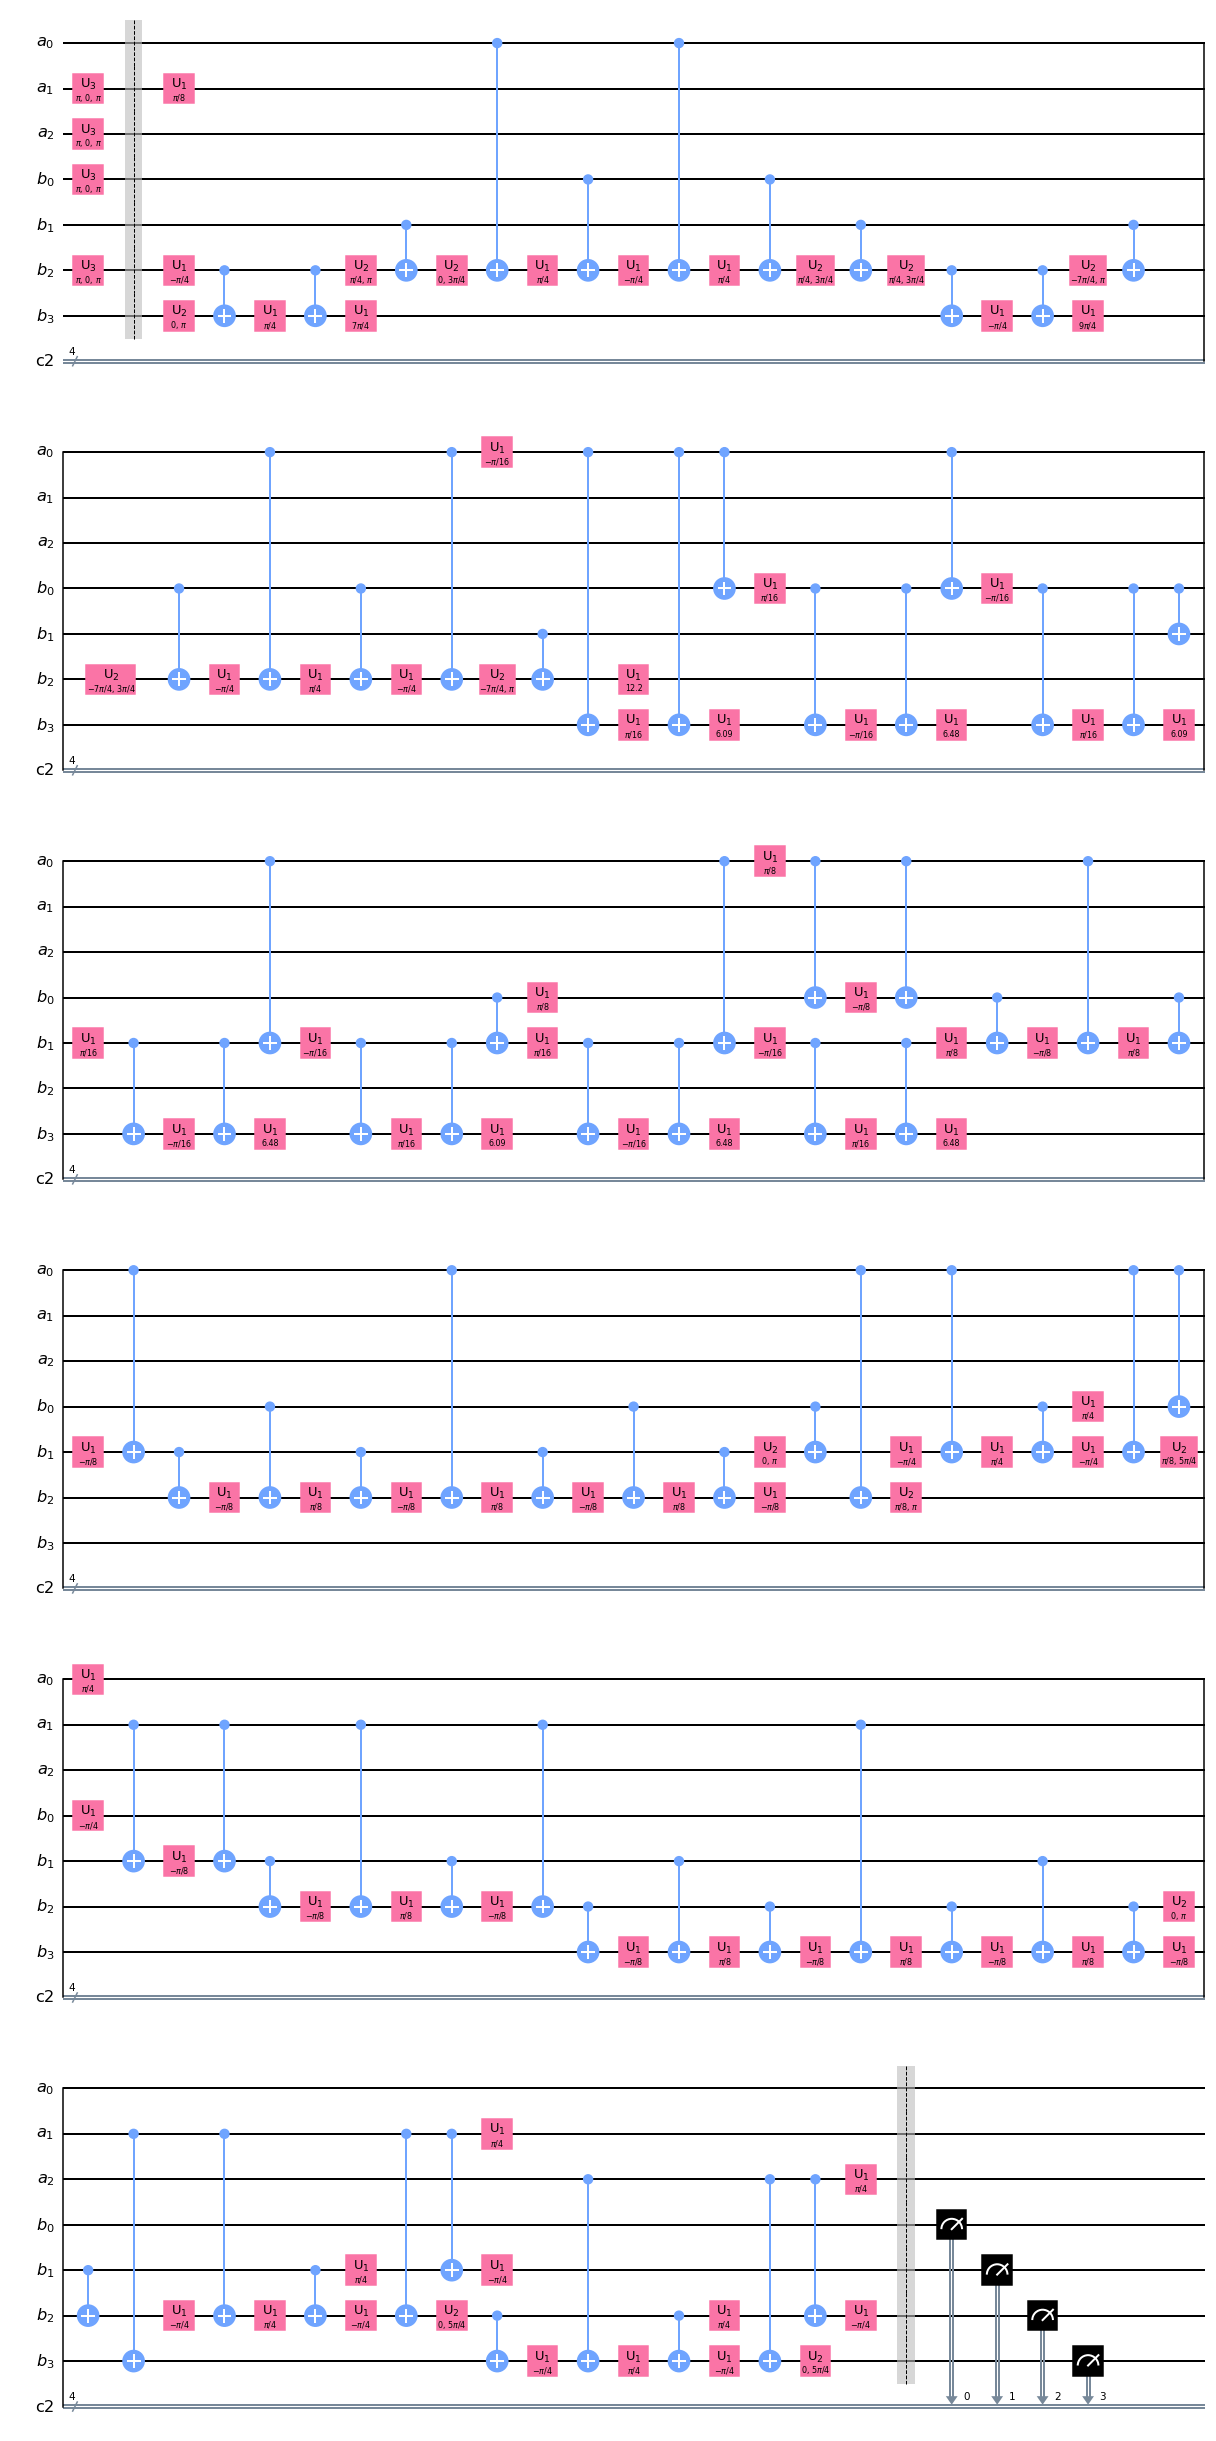

In [17]:
from qiskit.compiler import transpile

qc_transpile = transpile(qc_class, basis_gates=['u1', 'u2', 'u3', 'cx'])

qc_transpile.draw(output='mpl')

In [18]:
print("Cost of classical circuit = \n", qc_transpile.count_ops())

Cost of classical circuit = 
 OrderedDict([('cx', 79), ('u1', 77), ('u2', 14), ('u3', 4), ('measure', 4), ('barrier', 2)])


Alternatively, we can use QFT!

Assuming that registers A and B have been QFT'ed, we can compute their sum by doing...

In [25]:
from math import pi


def qft_add(x, y):
    n = len(x)
    
    A = QuantumRegister(n + 1, name="a")
    B = QuantumRegister(n + 1, name="b") # B has an extra bit in case the sum is > 4
    qc = QuantumCircuit(A, B, ClassicalRegister(n+1))
    
    #Step 1 - prepare inputs
    for i in range(n):
        if x[::-1][i] == "1": qc.x(A[i])
        
        if y[::-1][i] == "1": qc.x(B[i])
            
    qc.barrier()
    
    
    #Step 2 - QFT register B
    qc.append(QFT(n+1, do_swaps=False), B) #No swaps 
    
    qc.barrier()
    
    ##Step 3 - add
    for i in range(n+1):
        for j in range(i, n+1):
            qc.cp(pi/(2**(j-i)), A[n-j], B[i])
            #qc.cp(pi/(2**(j-i)), A[n-1-i], B[j])
            
        qc.barrier()
    
    qc.append(QFT(n+1, inverse=True, name='qft^+', do_swaps=False), B)

    qc.barrier()
    
    qc.measure(B, range(n+1))
    
    return qc


#qft_add('00000', '11111').draw(output='mpl')
    

{'0011': 1024}


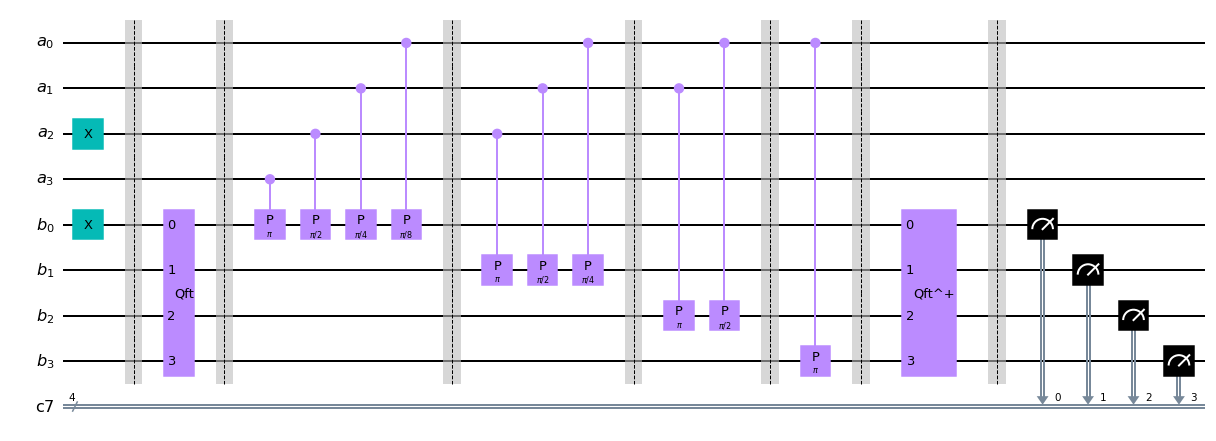

In [27]:
qc_q = qft_add('100', '001')
results = execute(qc_q, backend, shots=1024).result().get_counts()
print(results)
qc_q.draw(output='mpl')

OK, so let's compare the cost of this circuit:

In [18]:
qc_transpile = transpile(qc_q, basis_gates=['u1', 'u2', 'u3', 'cx'])

print("Cost of quantum circuit = \n", qc_transpile.count_ops())

Cost of quantum circuit = 
 OrderedDict([('u1', 48), ('cx', 36), ('u2', 8), ('barrier', 7), ('u3', 4), ('measure', 4)])


Almost half the number of u1's and cx's

We can also compare the accuracy on real devices:

In [1]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.providers(group='duke-uni-1')[0]

backend = provider.get_backend("ibmq_...")

import qiskit.tools.jupyter
%qiskit_job_watcher

/Users/edwinagnew/opt/anaconda3/envs/qc/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q-education', group='duke-uni-1', project='main')>
